In [1]:
from datetime import datetime
import numpy as np
import bw2data as bd
from bw_temporalis import TemporalDistribution

bd.projects.set_current("standalone_optimex_example_products")

/Users/timodiepers/anaconda3/envs/optimex/lib/python3.11/site-packages/scikits/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  __import__('pkg_resources').declare_namespace(__name__)


In [2]:
# BIOSPHERE
biosphere_data = {
    ("biosphere3", "CO2"): {
        "type": "emission",
        "name": "carbon dioxide",
        "CAS number": "000124-38-9"
    },
    ("biosphere3", "CH4"): {
        "type": "emission",
        "name": "methane, fossil",
        "CAS number": "000074-82-8"
    },
}
bd.Database("biosphere3").write(biosphere_data)

100%|██████████| 2/2 [00:00<00:00, 4364.52it/s]

09:09:08+0100 [info     ] Vacuuming database            


In [3]:
bd.Method(("GWP", "example")).write([
    (("biosphere3", "CO2"), 1),
    (("biosphere3", "CH4"), 27),
])

bd.Method(("land use", "example")).write([
    (("biosphere3", "CO2"), 2),
    (("biosphere3", "CH4"), 1),
])

In [4]:
# BACKGROUND 2020
db_2020_data = {
    ("db_2020", "I1"): {
        "name": "node I1",
        "location": "somewhere",
        "reference product": "I1",
        "exchanges": [
            {"amount": 1, "type": "production", "input": ("db_2020", "I1")},
            {"amount": 1, "type": "biosphere", "input": ("biosphere3", "CO2")},
        ],
    },
    ("db_2020", "I2"): {
        "name": "node I2",
        "location": "somewhere",
        "reference product": "I2",
        "exchanges": [
            {"amount": 1, "type": "production", "input": ("db_2020", "I2")},
            {"amount": 1, "type": "biosphere", "input": ("biosphere3", "CH4")},
        ],
    },
}
bg_2020 = bd.Database("db_2020")
bg_2020.write(db_2020_data)
bg_2020.metadata["representative_time"] = datetime(2020, 1, 1).isoformat() # optimex-specific: representative time of the background database
bg_2020.register()

# BACKGROUND 2030
db_2030_data = {
    ("db_2030", "I1"): {
        "name": "node I1",
        "location": "somewhere",
        "reference product": "I1",
        "exchanges": [
            {"amount": 1, "type": "production", "input": ("db_2030", "I1")},
            {"amount": 0.9, "type": "biosphere", "input": ("biosphere3", "CO2")},
        ],
    },
    ("db_2030", "I2"): {
        "name": "node I2",
        "location": "somewhere",
        "reference product": "I2",
        "exchanges": [
            {"amount": 1, "type": "production", "input": ("db_2030", "I2")},
            {"amount": 0.05, "type": "biosphere", "input": ("biosphere3", "CH4")},
        ],
    },
}
bg_2030 = bd.Database("db_2030")
bg_2030.write(db_2030_data)
bg_2030.metadata["representative_time"] = datetime(2030, 1, 1).isoformat() # optimex-specific: representative time of the background database
bg_2030.register()


09:09:08+0100 [warning  ] Not able to determine geocollections for all datasets. This database is not ready for regionalization.


100%|██████████| 2/2 [00:00<00:00, 32263.88it/s]

09:09:08+0100 [info     ] Vacuuming database            
09:09:08+0100 [warning  ] Not able to determine geocollections for all datasets. This database is not ready for regionalization.



100%|██████████| 2/2 [00:00<00:00, 33825.03it/s]

09:09:08+0100 [info     ] Vacuuming database            


In [5]:
from bw_temporalis import easy_timedelta_distribution

In [6]:
# FOREGROUND - temporally distributed
foreground_data = {
    ("foreground", "Product 1"): {
        "name": "Product 1",
        "unit": "kg",
        "type": bd.labels.product_node_default,
    },
    ("foreground", "P1R1"): {
        "name": "Product 1 production, Route 1",
        "location": "somewhere",
        "type": bd.labels.process_node_default,
        "operation_time_limits": (0,6), # Optimex-specific: start and end year of operation phase
        "exchanges": [
            {
                "amount": 1,
                "type": bd.labels.production_edge_default,
                "input": ("foreground", "Product 1"),
                "temporal_distribution": easy_timedelta_distribution(
                    start=1,
                    end=6,
                    steps=6,
                    resolution="Y",
                    kind="uniform"
                ),
                "operation": True, # Optimex-specific: indicates that this exchange is part of the operation phase
            },
            {
                "amount": 27.5,
                "type": bd.labels.consumption_edge_default,
                "input": ("db_2020", "I1"),
                "temporal_distribution": TemporalDistribution( # Optimex-specific: temporal distribution of the exchange)
                    date=np.array([11], dtype="timedelta64[Y]"),
                    amount=np.array([1]),
                ),
            },
            {
                "amount": 20,
                "type": bd.labels.biosphere_edge_default,
                "input": ("biosphere3", "CO2"),
                "temporal_distribution": easy_timedelta_distribution(
                    start=1,
                    end=6,
                    steps=6,
                    resolution="Y",
                    kind="uniform"
                ),
                "operation": True,
            },
        ],
    },
    ("foreground", "P1R2"): {
        "name": "Product 1 production, Route 2",
        "location": "somewhere",
        "type": bd.labels.process_node_default,
        "operation_time_limits": (0,11),
        "exchanges": [
            {
                "amount": 1,
                "type": bd.labels.production_edge_default,
                "input": ("foreground", "Product 1"),
                "temporal_distribution": easy_timedelta_distribution(
                    start=1,
                    end=11,
                    steps=11,
                    resolution="Y",
                    kind="uniform"
                ),
                "operation": True,
            },
            {
                "amount": 1,
                "type": bd.labels.consumption_edge_default,
                "input": ("db_2020", "I2"),
                "temporal_distribution": TemporalDistribution( # Optimex-specific: temporal distribution of the exchange)
                    date=np.array([11], dtype="timedelta64[Y]"),
                    amount=np.array([1]),
                ),
            },
            {
                "amount": 20,
                "type": bd.labels.biosphere_edge_default,
                "input": ("biosphere3", "CO2"),
                "temporal_distribution": easy_timedelta_distribution(
                    start=1,
                    end=11,
                    steps=11,
                    resolution="Y",
                    kind="uniform"
                ),
                "operation": True,
            },
        ],
    },
    
    # ------------------------------------------------------------
    
    ("foreground", "Product 2"): {
        "name": "Product 2",
        "unit": "kg",
        "type": bd.labels.product_node_default,
    },
    ("foreground", "P2R1"): {
        "name": "Product 2 production, Route 1",
        "location": "somewhere",
        "type": bd.labels.process_node_default,
        "operation_time_limits": (0,15), # Optimex-specific: start and end year of operation phase
        "exchanges": [
            {
                "amount": 1,
                "type": bd.labels.production_edge_default,
                "input": ("foreground", "Product 2"),
                "temporal_distribution": easy_timedelta_distribution(
                    start=1,
                    end=15,
                    steps=15,
                    resolution="Y",
                    kind="uniform"
                ),
                "operation": True, # Optimex-specific: indicates that this exchange is part of the operation phase
            },
            {
                "amount": 1,
                "type": bd.labels.consumption_edge_default,
                "input": ("foreground", "Product 1"),
                "temporal_distribution": easy_timedelta_distribution(
                    start=1,
                    end=15,
                    steps=15,
                    resolution="Y",
                    kind="uniform"
                ),
                "operation": True,
            },
            {
                "amount": 18.5,
                "type": bd.labels.consumption_edge_default,
                "input": ("db_2020", "I1"),
                "temporal_distribution": TemporalDistribution( # Optimex-specific: temporal distribution of the exchange)
                    date=np.array([0], dtype="timedelta64[Y]"),
                    amount=np.array([1]),
                ),
            },
            {
                "amount": 3,
                "type": bd.labels.biosphere_edge_default,
                "input": ("biosphere3", "CO2"),
                "temporal_distribution": easy_timedelta_distribution(
                    start=1,
                    end=15,
                    steps=15,
                    resolution="Y",
                    kind="uniform"
                ),
                "operation": True,
            },
        ],
    },
    ("foreground", "P2R2"): {
        "name": "Product 2 production, Route 2",
        "location": "somewhere",
        "type": bd.labels.process_node_default,
        "operation_time_limits": (0,7),
        "exchanges": [
            {
                "amount": 1,
                "type": bd.labels.production_edge_default,
                "input": ("foreground", "Product 2"),
                "temporal_distribution": easy_timedelta_distribution(
                    start=1,
                    end=7,
                    steps=7,
                    resolution="Y",
                    kind="uniform"
                ),
                "operation": True,
            },
            {
                "amount": 1,
                "type": bd.labels.consumption_edge_default,
                "input": ("foreground", "Product 1"),
                "temporal_distribution": easy_timedelta_distribution(
                    start=1,
                    end=7,
                    steps=7,
                    resolution="Y",
                    kind="uniform"
                ),
                "operation": True,
            },
            {
                "amount": 15.5,
                "type": bd.labels.consumption_edge_default,
                "input": ("db_2020", "I2"),
                "temporal_distribution": TemporalDistribution( # Optimex-specific: temporal distribution of the exchange)
                    date=np.array([0], dtype="timedelta64[Y]"),
                    amount=np.array([1]),
                ),
            },
            {
                "amount": 0,
                "type": bd.labels.biosphere_edge_default,
                "input": ("biosphere3", "CO2"),
                "temporal_distribution": easy_timedelta_distribution(
                    start=1,
                    end=7,
                    steps=7,
                    resolution="Y",
                    kind="uniform"
                ),
                "operation": True,
            },
        ],
    },
}
fg = bd.Database("foreground")
fg.write(foreground_data)
fg.register()

09:09:08+0100 [warning  ] Not able to determine geocollections for all datasets. This database is not ready for regionalization.


100%|██████████| 6/6 [00:00<00:00, 10322.32it/s]

09:09:08+0100 [info     ] Vacuuming database            


### Defining Demand of Functional Unit in `optimex`

In [7]:
# Define temporally distributed demand from 2020 to 2030
years = range(2025, 2050)
rng = np.random.default_rng(42)
td_demand = TemporalDistribution(
    date=np.array([datetime(year, 1, 1).isoformat() for year in years], dtype="datetime64[s]"),
    amount=rng.random(len(years)) * 10,
)
functional_demand = {bd.get_node(database="foreground", name="Product 2"): td_demand}

## optimex

In [8]:
from optimex import lca_processor

lca_config = lca_processor.LCAConfig(
    demand = functional_demand,
    temporal= {
        "start_date": datetime(2020, 1, 1),
        "temporal_resolution": "year",
        "time_horizon": 100,
    },
    characterization_methods=[
        {
            "category_name": "climate_change",
            "brightway_method": ("GWP", "example"),
            # "metric": "CRF",
        },
        # {
        #     "category_name": "land_use",
        #     "brightway_method": ("land use", "example"),
        # },
    ],
)

With all the necessary components defined, we are now ready to gather the LCI and prepare for optimization.

To summarize, we have:

- Defined a **custom biosphere** with elementary flows (e.g., CO₂, CH₄).
- Created **foreground** and **background** systems, including temporal distributions.
- Registered **characterization methods** (static or dynamic).
- Specified **demand over time** using `TemporalDistribution`.
- Marked processes as **functional flows** to indicate eligible supply routes.
- (Optionally) Enabled **dynamic characterization** for more time-sensitive impact assessment.

In [9]:
lca_data_processor = lca_processor.LCADataProcessor(lca_config)

2025-12-17 09:09:08.592 | INFO     | optimex.lca_processor:_parse_demand:385 - Identified demand in system time range of %s for products %s
2025-12-17 09:09:08.600 | INFO     | optimex.lca_processor:_construct_foreground_tensors:521 - Constructed foreground tensors.
2025-12-17 09:09:08.600 | INFO     | optimex.lca_processor:log_tensor_dimensions:516 - Technosphere (external) shape: (4 processes, 2 flows, 2 years) with 4 total entries.
2025-12-17 09:09:08.601 | INFO     | optimex.lca_processor:log_tensor_dimensions:516 - Internal demand shape: (2 processes, 1 flows, 15 years) with 22 total entries.
2025-12-17 09:09:08.601 | INFO     | optimex.lca_processor:log_tensor_dimensions:516 - Biosphere shape: (4 processes, 1 flows, 15 years) with 39 total entries.
2025-12-17 09:09:08.601 | INFO     | optimex.lca_processor:log_tensor_dimensions:516 - Production shape: (4 processes, 2 flows, 15 years) with 39 total entries.
2025-12-17 09:09:08.601 | INFO     | optimex.lca_processor:_calculate_inve

In [10]:
from optimex import converter
manager = converter.ModelInputManager()
optimization_model_inputs = manager.parse_from_lca_processor(lca_data_processor) 

### Saving and Reusing Model Inputs

Gathering all LCA-relevant data—including biosphere flows, foreground and background systems, temporal distributions, and characterization methods—can be **computationally expensive**.  
If you're working with similar scenarios or want to explore different optimization settings, it's often unnecessary to rebuild the entire setup from scratch.

 `OptimizationModelInputs`: Interface for Efficient Reuse

To address this, `optimex` provides a dedicated interface called **`OptimizationModelInputs`**. This object:

- Collects all the structured LCA data needed for optimization.
- Can be **saved** to disk for future use.
- Can be **loaded** later to resume or modify the scenario.
- Allows you to tweak configurations (e.g., demand, technologies, time horizon) without re-running the full data setup.

In the next steps, we’ll create and populate a `OptimizationModelInputs` object, and use it to prepare for running the optimization in `optimex`.

In [11]:
from optimex import converter
manager = converter.ModelInputManager()

In [12]:
optimization_model_inputs = manager.parse_from_lca_processor(lca_data_processor) 
# manager.save("model_inputs.json") # if you want to save the model inputs to a file
# manager.load("model_inputs.json") # if you want to load the model inputs from a file
optimization_model_inputs.model_dump()

{'PROCESS': ['P2R1', 'P1R1', 'P2R2', 'P1R2'],
 'PRODUCT': ['Product 2', 'Product 1'],
 'INTERMEDIATE_FLOW': ['I1', 'I2'],
 'ELEMENTARY_FLOW': ['CO2', 'CH4'],
 'BACKGROUND_ID': ['db_2020', 'db_2030'],
 'PROCESS_TIME': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
 'SYSTEM_TIME': [2020,
  2021,
  2022,
  2023,
  2024,
  2025,
  2026,
  2027,
  2028,
  2029,
  2030,
  2031,
  2032,
  2033,
  2034,
  2035,
  2036,
  2037,
  2038,
  2039,
  2040,
  2041,
  2042,
  2043,
  2044,
  2045,
  2046,
  2047,
  2048,
  2049],
 'CATEGORY': ['climate_change'],
 'demand': {('Product 2', 2025): 7.739560485559633,
  ('Product 2', 2026): 4.388784397520523,
  ('Product 2', 2027): 8.585979199113824,
  ('Product 2', 2028): 6.973680290593639,
  ('Product 2', 2029): 0.9417734788764953,
  ('Product 2', 2030): 9.756223516367559,
  ('Product 2', 2031): 7.61139701990353,
  ('Product 2', 2032): 7.860643052769538,
  ('Product 2', 2033): 1.2811363267554587,
  ('Product 2', 2034): 4.503859378955672,
  ('Pro

### Creating the Optimization Model

With the `OptimizationModelInputs` object prepared, we can now **populate the optimization model** in `optimex`.

This step involves specifying:

- A **name** for the model,
- The **impact category** to be minimized (e.g., `"climate_change"`),
- Whether to enable **flexible operation** (i.e., allow processes to run at varying capacity over time).


In [13]:
from optimex import optimizer

model = optimizer.create_model(
    optimization_model_inputs,
    name = "demo_simple_example",
    objective_category = "climate_change",
)

2025-12-17 09:09:09.319 | INFO     | optimex.optimizer:create_model:123 - Creating sets
2025-12-17 09:09:09.320 | INFO     | optimex.optimizer:create_model:165 - Creating parameters
2025-12-17 09:09:09.321 | INFO     | optimex.optimizer:create_model:337 - Creating variables


## Solving the Optimization Model

Once the model is created, you can solve it using available solvers such as **GLPK** or **Gurobi**.

Use the `solve_model` function from `optimex` to run the optimization. It offers several parameters to control solver options, convergence criteria, and output verbosity.

For detailed information on all parameters and solver configurations, please refer to the documentation.

In [14]:
m, obj, results = optimizer.solve_model(model, solver_name="glpk", tee=False) # choose solver here, e.g. "gurobi", "cplex", "glpk", etc.

2025-12-17 09:09:09.474 | INFO     | optimex.optimizer:solve_model:694 - Solver [glpk] termination: optimal
2025-12-17 09:09:09.484 | INFO     | optimex.optimizer:solve_model:719 - Objective (scaled): 4.98868
2025-12-17 09:09:09.484 | INFO     | optimex.optimizer:solve_model:720 - Objective (real):   3704.1


## Postprocessing the Optimization Results

`optimex` offers powerful tools to analyze and visualize the optimal solution in detail. Key aspects you can explore include:

- **Impact over time:** View time-resolved environmental impacts according to the chosen impact category.
- **Demand fulfillment:** Track how the demand for the functional product evolves and by which processes it is met during the modeled period.
- **Installation timeline:** Identify when each process was installed during the transition pathway.
- **Operation profiles:** Examine the operational levels of processes year-by-year, especially important for flexible operation scenarios.
- **Production of functional flows:** Analyze how much of the functional product each process produces over time.

Together, these outputs provide a comprehensive understanding of the system’s dynamics, helping you evaluate trade-offs and the timing of interventions. Below is a demosntartion of some postprocessing tools.


In [15]:
from optimex import postprocessing
pp = postprocessing.PostProcessor(m)

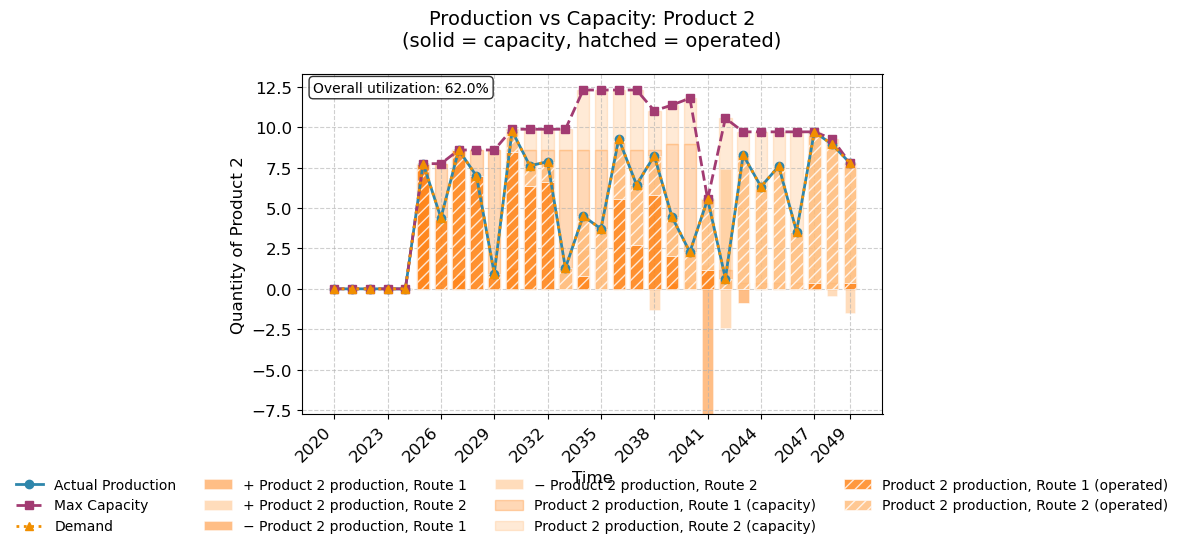

In [21]:
pp.plot_production_vs_capacity(show_capacity_changes=True, show_process_utilization=True)

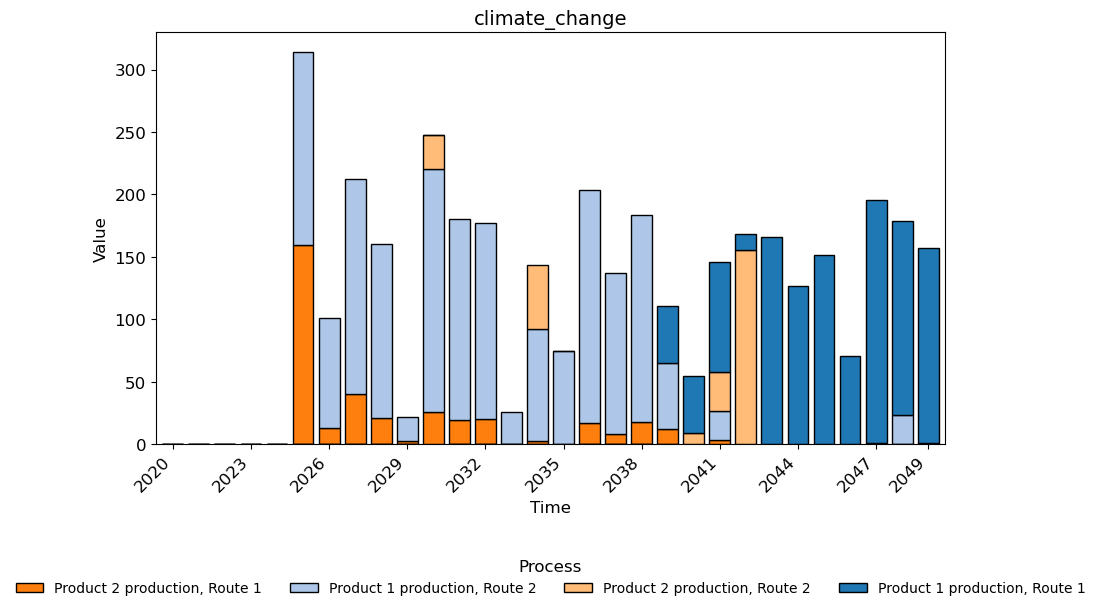

In [29]:
pp.plot_impacts()

In [19]:
pp.get_demand()

Product,Product 1,Product 2
Time,,
2020,0.0,0.000000
2021,0.0,0.000000
2022,0.0,0.000000
2023,0.0,0.000000
2024,0.0,0.000000
2025,0.0,7.739560
2026,0.0,4.388784
2027,0.0,8.585979
2028,0.0,6.973680


In [24]:
pp.get_installation()

Process,P1R1,P1R2,P2R1,P2R2
Time,,,,
2020,0.000000,6.699527,0.000000,0.000000
2021,0.000000,0.000000,0.000000,0.000000
2022,0.000000,0.000000,0.000000,0.000000
2023,0.000000,0.000000,0.000000,0.000000
2024,0.000000,0.000000,0.000000,0.000000
2025,0.000000,1.040034,7.739560,0.000000
2026,0.000000,0.000000,0.000000,0.000000
2027,0.000000,0.846419,0.846419,0.000000
2028,0.000000,7.381197,0.000000,0.000000


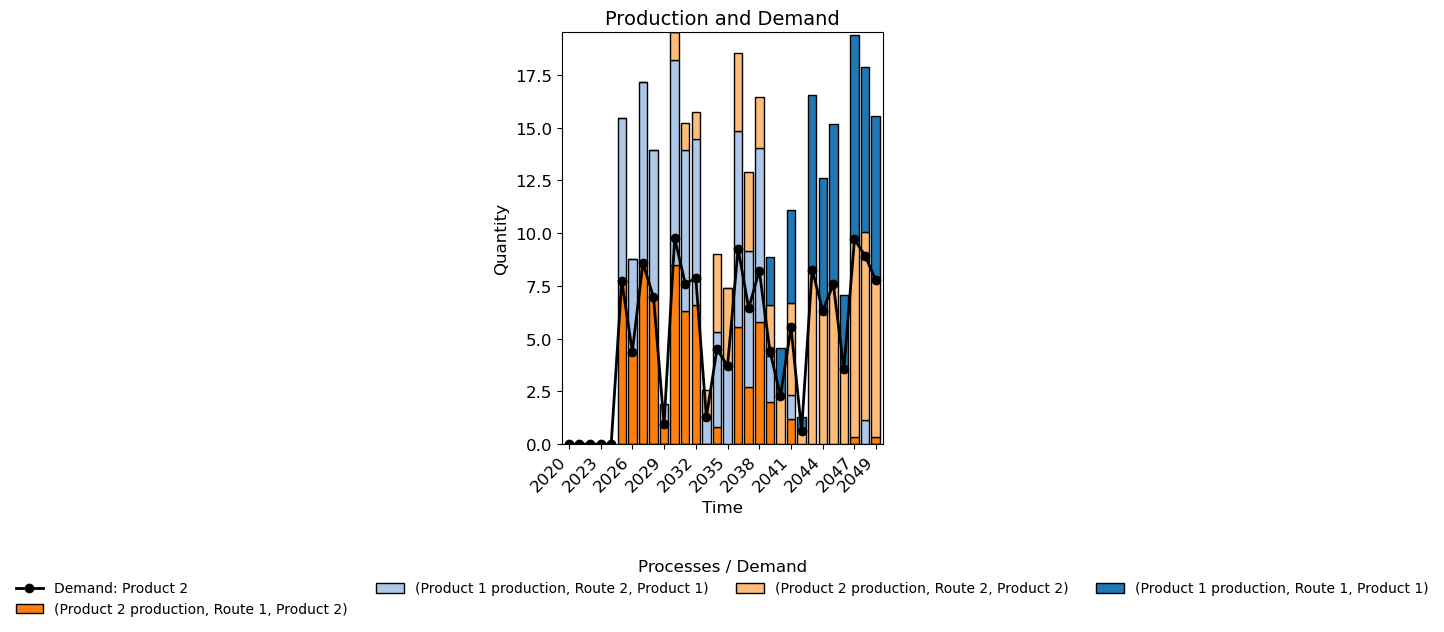

In [25]:
pp.plot_production_and_demand()